# Imputation

## Motivation 
Unlike spot-based spatial transcriptomics, targeted in-situ technologies (such as MERFISH, smFISH, or seqFISH+) are not limited in their spatial resolution but gene throughput, typically limited to a few hundreds of preselected genes. As a consequence, we face the orthogonal problem of increasing resolution with respect to genes instead of increasing spatial resolution and identifying cellular features. Hence, we would like to impute genes that are measured in scRNA-seq but not in FISH-based technologies.

## Constructing a map between technologies

A method that is widely applicable in the context of aligning spatial profiling measurements with common sc/snRNA-seq profiles is Tangram{cite}`biancalani_deep_2021`. An independent benchmark{cite}`li_benchmarking_2022` showed that Tangram outperformed other imputation methods like gimVI{cite}`DBLP:journals/corr/abs-1905-02269` and SpaGE{cite}`10.1093/nar/gkaa740` in terms of different accuracy metrics and scalability. While Tangram can also be applied in the previously described deconvolution context, we focus on its ability to map MERFISH data to whole genome expression profiles. The underlying idea of Tangram is the probabilistic alignment of two different technologies by means of a single shared modality, typically RNA-seq data. This way, limitation with respect to the number of genes that are measured or spatial resolution can be overcome. 

The mapping algorithm of Tangram builds on count matrices from the two technologies at hand. For sc/snRNa-seq data, this means to compute the matrix $S$ whose entry $S_{ik}$ indicates the expression level for cell $i$ and gene $k$: 

$$S \in \mathbb{R}_+^{n_{\text{cells}}\times n_{\text{genes}}} \ \ \text{ with } \ \ S_{ik}>0 \quad . $$

The same procedure applies to spatial data. We build the matrix $G$ according to: 

$$ G \in \mathbb{R}_+^{n_{\text{voxels}}\times n_{\text{genes}}} \ \ \text{ with } \ \ G_{jk}>0 $$

For MERFISH data, a voxel means the aggregation of single gene measurements to individual cells while a voxels refers to the individual spots for Visium. Note that the specific order in the voxel dimension is arbitrary and that $n_genes$ corresponds to the shared subset of genes present in both technologies. 

<!-- I am not sure what the density for MERFISH would look like, all ones maybe? -->
Tangram makes further use of a voxel density vector $\textbf d$. This density corresponds to estimated cell densities which, for example, can be deduced from an image segmentation in the case of Visium data. Formally, we write: 

$$ \textbf{d} \in \mathbb{R}^{n_\text{voxels}} \ \ \text{ with } \ \ d_j \in [0,1]  \ \ \text{ and } \ \ \sum_j d_j = 1 \quad . $$  

Given the matrices $S$ and $G$ as well as the density $\textbf d$, Tangram aims to learn a thrid matrix $M$ that expresses the probability $M_{ij} \in [0,1]$ that cell $i$ belongs to voxel $j$. Being probabilitistic, every cells has to be mapped exactly once, that is the rows of $M$ have to be normalised: 

$$ M \in \mathbb{R}^{n_{\text{cells}}\times n_{\text{voxels}}}_+ \ \ \text{ with } \ \ \sum_{j}^{n_\text{voxel}} M_{ij}=1 \quad . $$

Note that the sum across cells indicates the number of cells that are assigned to a voxel $j$. Knowing about the number of cells in $S$, we can estimate the voxel density as 

$$ m_j = \sum_{i}^{n_\text{cells}} \frac{M_{ij}}{n_\text{cells}} \quad . $$

Putting all parts together, we arrive at the objective function of Tangram: 

$$ L = \mathbb{KL}[\mathbf m, \mathbf d] - \sum_{k}^{n_\text{genes}} d_{\cos}(M^TS_{:k}, G_{:k}) - \sum_{j}^{n_\text{voxels}} d_{\cos}(M^TS_{j:}, G_{j:}) \quad , $$

where $M^TS$ is the predicted spatial gene expression, $\mathbb{KL}$ the Kullback-Leibler divergence and $d_{\cos}$ the cosine similarity. The first term matches the predicted voxel density $\textbf m$ with the estimated one $\textbf d$. The second term ensures that for each gene $k$ the predicted profile matches the expected profile from $G$. The third term serves the same purpose for each individual voxel: the predicted voxel expression should be close to the expected one from $G$. 

<!-- For MERFISH we have to use the filtered approach, maybe to cumbersome to introduce it? -->
In order to infer genome-scale expression maps for MERFISH data, we first identify the shared gene set which should result in about $\sim 200$ genes. Second, we compute the $S$ and $G$ matrices from the sc/scRNA-seq reference and the spatial assay, respectively. For MERFISH, the voxel density has uniform entries $1/n_{\text{voxels}}$ as the voxels correspond to cells themselve. Given this, we only have to optimise the obective $L$ and obtain the probabilistic mapping $M$. 

To infer the spatial expression for the whole genome $f_j$ for voxel $j$, one can either compute a weighted sum using the probabilistic cell assignments $f_j = \sum_i M_{ij} c_i$, where $c_i \in \mathbb{R}_+^{n'_\text{genes}}$ is the genome-wide expression profile from sc/snRNA-seq, or first compute a deterministic mapping via $i^*(j) = \arg\max_i M_{ij}$ and then build the genome-scale profile as $f_j = c_{i^*(j)}$ . 

## Using Tangram in practise

:::{figure-md} imputation

<img src="../_static/images/spatial/imputation_2.jpeg" alt="Imputation Overview" class="bg-primary mb-1" width="800px">

Imputation methods leverage a whole transcriptome reference dataset to map cells onto space. Tangram learns a mapping matrix between the reference and the spatial dataset on the common gene set. 
:::

Before we enter this notebook’s analysis, let’s set up our environment.

In [1]:
import scanpy as sc
import tangram as tg
import seaborn as sns
import pandas as pd
import moscot as mt
import squidpy as sq
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

sc.settings.verbosity = 3
sc.settings.set_figure_params(dpi=80, facecolor="white")

The dataset used in this tutorial was measured by multiplexed error robust fluorescence in situ hybridization (MERFISH) and investigates the spatial organization and transcriptional profile of wild type hematopoietic stem cell (HSC) niches in fetal liver{cite}`lu_spatial_2021`. The dataset contains 140 images across four fetal livers at E14.5 with 132 genes observed in 40,864 cells. Lu et al.{cite}`lu_spatial_2021` additionally performed single-cell RNA sequencing of E14.5 whole fetal liver cells by 10x Genomics platform, which we will use as a whole transcriptome reference for this tutorial. 

We will first load the reference dataset.

In [2]:
adata_sc = mt.datasets.drosophila(spatial=False)
adata_st = mt.datasets.drosophila(spatial=True)
adata_sc, adata_st

(AnnData object with n_obs × n_vars = 1297 × 2000
     obs: 'n_counts'
     var: 'n_counts', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
     uns: 'hvg', 'log1p', 'pca'
     obsm: 'X_pca'
     varm: 'PCs'
     layers: 'counts',
 AnnData object with n_obs × n_vars = 3039 × 82
     obs: 'n_counts'
     var: 'n_counts'
     uns: 'log1p', 'pca'
     obsm: 'X_pca', 'spatial'
     varm: 'PCs'
     layers: 'counts')

The single-cell RNA-seq reference we are using to showcase the usage of Tangram is not annotated. We therefore apply a basic processing to obtain leiden clusters which we can later project onto the spatial dataset.

computing neighbors
    using 'X_pca' with n_pcs = 50


OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:02)
running Leiden clustering
    finished: found 6 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:00)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:01)


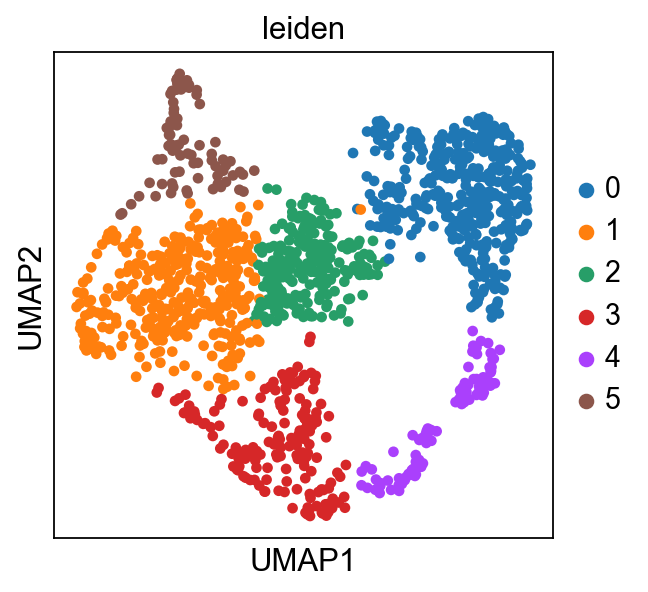

In [3]:
sc.pp.neighbors(adata_sc)
sc.tl.leiden(adata_sc, resolution=0.25)
sc.tl.umap(adata_sc)
sc.pl.umap(adata_sc, color="leiden")

Next, we load the spatial transcriptomics dataset. The MERFISH dataset contains data from X different field of views (FOV).

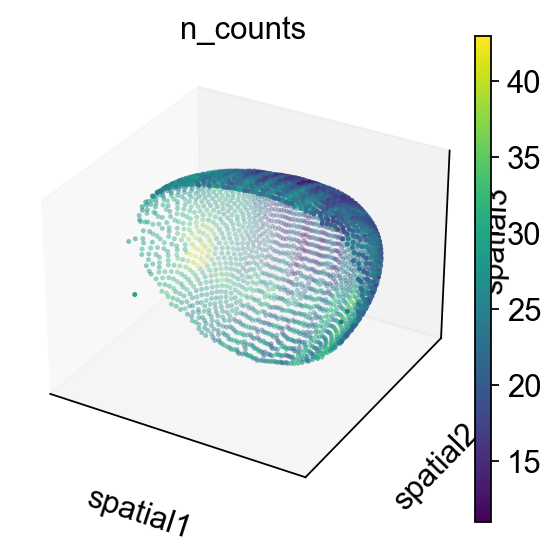

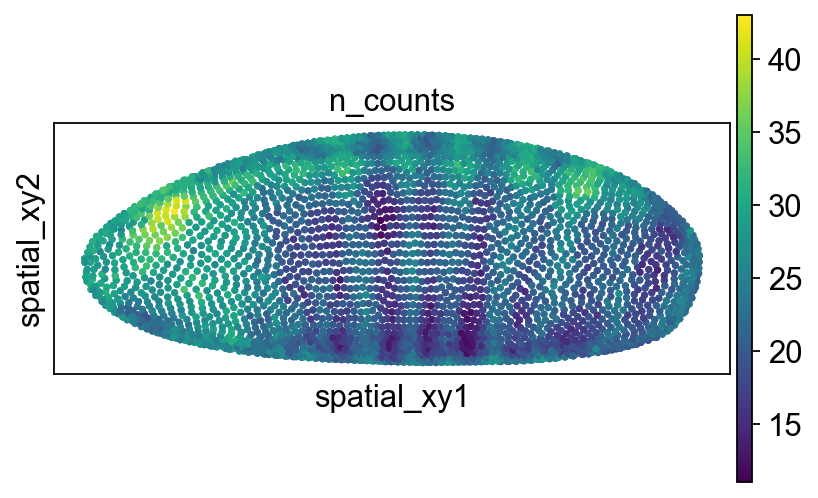

In [5]:
sc.pl.embedding(
    adata_st,
    basis="spatial",
    color="n_counts",
    projection="3d",
    na_color=(1, 1, 1, 0),
)
adata_st.obsm["spatial_xy"] = adata_st.obsm["spatial"][:, [0, 2]]
sq.pl.spatial_scatter(
    adata_st,
    spatial_key="spatial_xy",
    color="n_counts",
    shape=None,
    size=20,
    figsize=(5, 3),
)

### Common gene set between reference and spatial dataset

We want to select our training genes. These genes are shared between the two datasets and should capture the biological variance between cell types. For this, we first compute marker genes on the single-cell data and then use Tangram's preprocessing function to subset to those genes that are also present in the spatial data.

In [6]:
adata_sc.var_names

Index(['14-3-3epsilon', '18w', '4EHP', '5-HT1A', '5-HT1B', '5-HT2A', 'a',
       'A2bp1', 'aay', 'ab',
       ...
       'Yp3', 'yrt', 'z', 'Z600', 'Zasp52', 'zen', 'zen2', 'zfh1', 'zfh2',
       'Zip71B'],
      dtype='object', length=2000)

In [7]:
adata_st.var_names

Index(['croc', 'zfh1', 'run', 'ImpL2', 'CG8147', 'CG17724', 'rho', 'Esp',
       'tll', 'Blimp-1', 'MESR3', 'edl', 'bmm', 'hkb', 'Ama', 'knrl', 'dan',
       'Kr', 'E(spl)m5-HLH', 'zen', 'cnc', 'CG10479', 'Ilp4', 'CG14427', 'lok',
       'cad', 'gk', 'Dfd', 'D', 'sna', 'CG43394', 'Mdr49', 'Antp', 'noc',
       'erm', 'mfas', 'pxb', 'bun', 'twi', 'exex', 'apt', 'ems', 'Doc3', 'tsh',
       'Mes2', 'CenG1A', 'Cyp310a1', 'fkh', 'rau', 'ftz', 'aay', 'odd', 'dpn',
       'srp', 'toc', 'nub', 'eve', 'peb', 'Ance', 'Nek2', 'danr', 'NetA', 'hb',
       'ken', 'h', 'tkv', 'bowl', 'gt', 'disco', 'Btk29A', 'kni', 'Doc2',
       'zen2', 'ImpE2', 'Traf4', 'htl', 'fj', 'oc', 'trn', 'prd', 'numb',
       'brk'],
      dtype='object')

In [3]:
markers = list(set(adata_sc.var_names.values).intersection(set(adata_st.var_names.values)))
len(markers)

82

`tg.pp_adatas` does the following: 
- Computes the overlap between single-cell data and spatial data on the list of genes provided in the `genes` argument
- Stores the resulting gene set under `'training_genes'` in both adata objects under the `.uns` key
- Enforces consistent ordering of the genes
- To reduce potential naming errors gene names are converted to lower case. To prevent this behaviour set ` gene_to_lowercase = False`.

In [9]:
tg.pp_adatas(adata_sc, adata_st, genes=markers)

INFO:root:82 training genes are saved in `uns``training_genes` of both single cell and spatial Anndatas.
INFO:root:82 overlapped genes are saved in `uns``overlap_genes` of both single cell and spatial Anndatas.
INFO:root:uniform based density prior is calculated and saved in `obs``uniform_density` of the spatial Anndata.
INFO:root:rna count based density prior is calculated and saved in `obs``rna_count_based_density` of the spatial Anndata.


Let us check that the function performs as we expect:

In [10]:
assert "training_genes" in adata_sc.uns
assert "training_genes" in adata_st.uns

print(f"Number of training_genes: {len(adata_sc.uns['training_genes'])}")

Number of training_genes: 82


### Computing the map from single-cells to spatial voxels

Having specified the training genes, we can now create the map from dissociated single-cell measurements to the spatial locations. For this, we are going to use the `maps_cells_to_space` function from tangram. This function has two different modes, `mode='cells'` and `mode='clusters'`. The latter only maps averaged single-cells which makes computationally faster and more robust when mapping between specimen. However, as we are interested in imputing our spatial data, we will rely on the cell mode which might require access to a GPU for reasonable runtime.

In [11]:
ad_map = tg.map_cells_to_space(
    adata_sc,
    adata_st,
    mode="cells",
    density_prior="rna_count_based",
    num_epochs=500,
    # device="cuda",  # or: cpu
)

INFO:root:Allocate tensors for mapping.
INFO:root:Begin training with 82 genes and rna_count_based density_prior in cells mode...
INFO:root:Printing scores every 100 epochs.


Score: 0.491, KL reg: 0.002
Score: 0.857, KL reg: 0.001
Score: 0.861, KL reg: 0.001
Score: 0.861, KL reg: 0.001
Score: 0.862, KL reg: 0.001


INFO:root:Saving results..


The resulting `ad_map` is itself an AnnData object. Let us inspect it:

In [30]:
ad_map

AnnData object with n_obs × n_vars = 1297 × 3039
    obs: 'n_counts', 'leiden'
    var: 'n_counts', 'uniform_density', 'rna_count_based_density'
    uns: 'train_genes_df', 'training_history'

We observe that Tangram's mapping from cell i to spatial voxels j is stored in the `.X` property of `ad_map`

Hence, the meaning of the `.var` and `.obs` also changes: 
- in `.var` have the available metadata of the spatial data, `adata_st`
- in `.obs` have the available metadata of the single-cell data, `adata_sc`

In addition, the information about the training run is stored in the `.uns` key, see `.uns['training_genes_df']` and `.uns[training_history]`.

### Imputing genes and mapping cell-types to space

We can use this result in two ways. First, we can map the cell type information that was originally only present in the single-cell data to space. This an easy way to check that your results are biologically consistent by looking for known cell type patterns. Second, we can investigate the spatial gene-expression of those genes that have not been measured with the in-situ method in the first place, effectively imputing all the missing genes.

INFO:root:spatial prediction dataframe is saved in `obsm` `tangram_ct_pred` of the spatial AnnData.


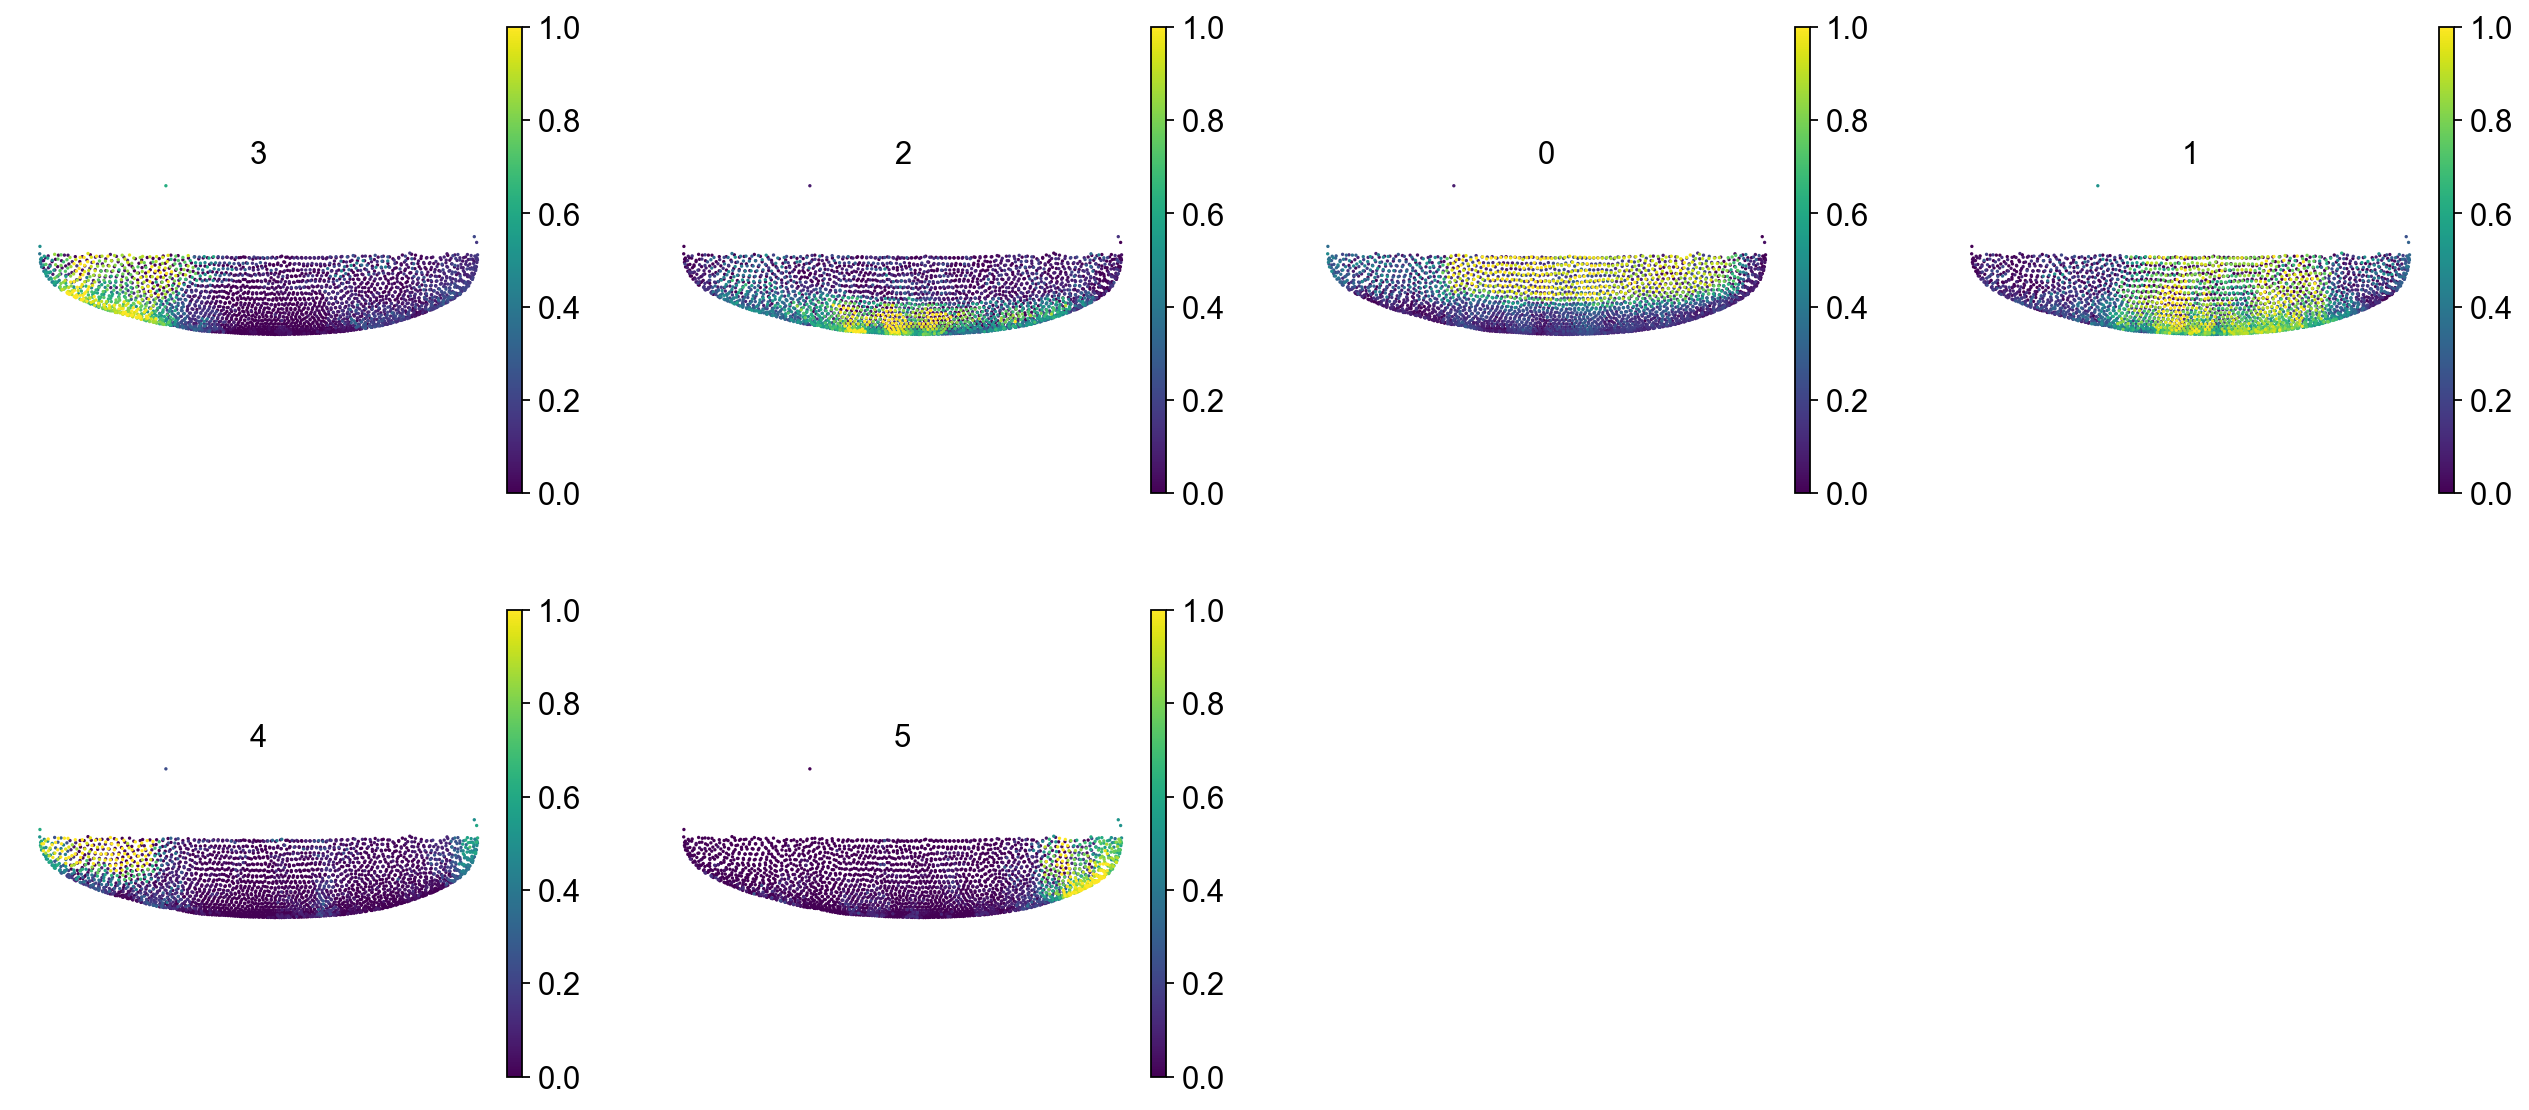

In [16]:
# Project the cell annotation to spatial locations
tg.project_cell_annotations(ad_map, adata_st, annotation="leiden")
annotation_list = list(pd.unique(adata_sc.obs["leiden"]))

# Plot the spatial annotation
# The `perc` argument steers the range of the colourmap and can help with removing outliers.
tg.plot_cell_annotation_sc(
    adata_st, annotation_list, perc=0.02, spot_size=3
)

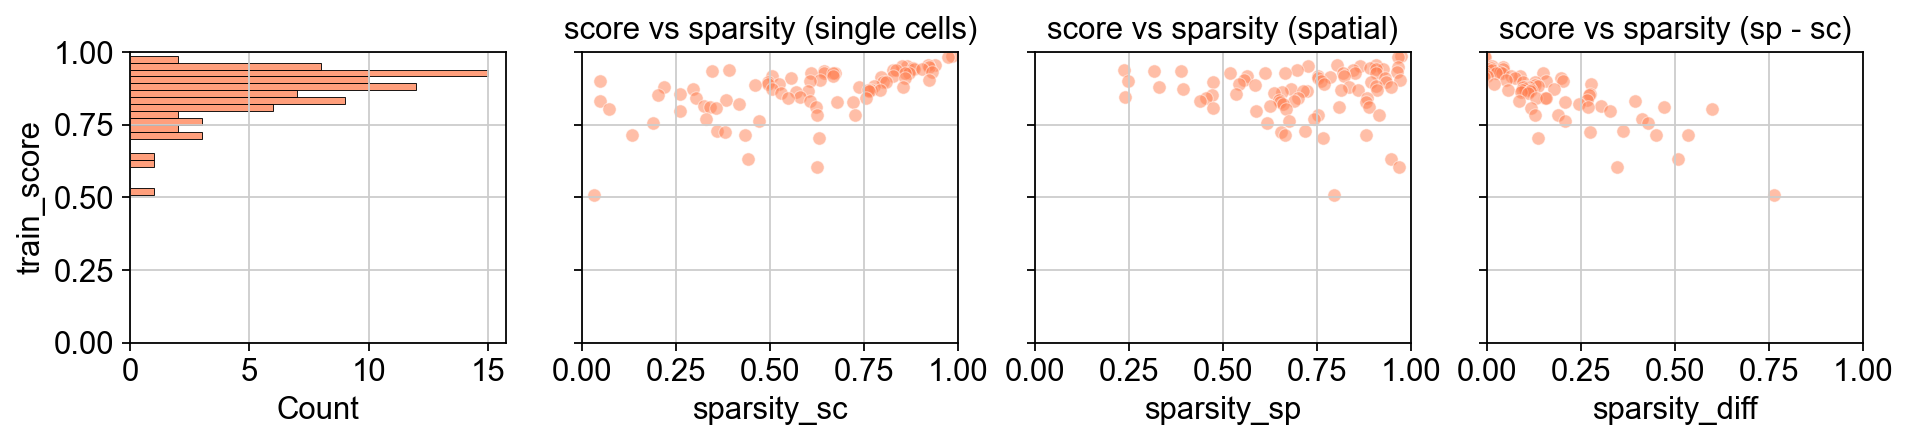

In [17]:
#  To get a deeper sense, Tangram also computes several scores, which are readily plotted
tg.plot_training_scores(ad_map, bins=20, alpha=0.5)

The score generally measures the similarity between original measurement (by the spatial technology) and the inferred mapping by single-cell data. The middle panels both relate the sparsity of the respective data, single-cell and spatial, of a training genes (each dot is a training gene) with the achieved score. As you can see, the performance is much more correlated with the spatial data which is often more sparse and therefore responsible for low-quality mappings. The last panel sets both technologies in context. Genes that have similar sparsity levels in both spatial and single-cell data usually achieve better scores than those that are inconsistent across technologies. 

Minor remark: The similarity that Tangram builds on is cosine similarity.

Even more detailed information can be found in the `.uns["train_genes_df"]`.

To genes new spatial data, we can project the genes present in the single-cell data to the spatial locations. This is easily achieved by multiplying the mapping matrix stored in `ad_map` with the original single-cell data stored in `adata_sc`. Tangram already provides a convenience function which takes in a mapping and the corresponding single-cell data. The result is a spatial voxel by genes matrix which technically is identical to the original spatial data `adata_st` but contains expression values for all genes.

In [18]:
ad_ge = tg.project_genes(adata_map=ad_map, adata_sc=adata_sc)
ad_ge

AnnData object with n_obs × n_vars = 3039 × 2000
    obs: 'n_counts', 'uniform_density', 'rna_count_based_density'
    var: 'n_counts', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'n_cells', 'sparsity', 'is_training'
    uns: 'hvg', 'log1p', 'pca', 'neighbors', 'leiden', 'umap', 'leiden_colors', 'training_genes', 'overlap_genes'

Next, we will compare the new spatial data with the orignial measurments. This will provide us with a better feeling why some training scores might be bad. Note that this explicit mapping of Tangram relies on entirely different premises than those in probabilistic models. Here, we are inclined to trust the predicted gene expression patterns based on the good mapping performance of most training genes. The fact the some genes show a very sparse and dispersed spatial signal can be understood a result of technical dropout of the spatial technology rather than a shortcoming of the mapping method.

In [23]:
ad_map.uns["train_genes_df"].index.unique()

Index(['erm', 'exex', 'croc', 'tll', 'gk', 'fkh', 'ceng1a', 'hkb', 'dfd',
       'ems', 'danr', 'hb', 'oc', 'cg43394', 'nek2', 'cad', 'zen', 'impe2',
       'nub', 'htl', 'eve', 'brk', 'esp', 'neta', 'ftz', 'doc2', 'sna', 'ken',
       'zen2', 'dpn', 'dan', 'mdr49', 'rau', 'cnc', 'prd', 'pxb', 'mes2', 'kr',
       'ance', 'impl2', 'bowl', 'peb', 'cg8147', 'twi', 'cg17724', 'disco',
       'doc3', 'gt', 'rho', 'mesr3', 'blimp-1', 'tsh', 'trn', 'cg14427',
       'btk29a', 'mfas', 'toc', 'lok', 'ama', 'bmm', 'kni', 'e(spl)m5-hlh',
       'odd', 'run', 'knrl', 'cyp310a1', 'numb', 'ilp4', 'h', 'srp', 'd',
       'apt', 'aay', 'traf4', 'cg10479', 'tkv', 'antp', 'noc', 'fj', 'edl',
       'zfh1', 'bun'],
      dtype='object')

In [24]:
genes = ["croc", "zfh1", "zen2"]
ad_map.uns["train_genes_df"].loc[genes]

,train_score,sparsity_sc,sparsity_sp,sparsity_diff
croc,0.957609,0.937548,0.907535,-0.030013
zfh1,0.604096,0.623747,0.967753,0.344005
zen2,0.905537,0.921357,0.972359,0.051002


In [25]:
ad_ge

AnnData object with n_obs × n_vars = 3039 × 2000
    obs: 'n_counts', 'uniform_density', 'rna_count_based_density'
    var: 'n_counts', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'n_cells', 'sparsity', 'is_training'
    uns: 'hvg', 'log1p', 'pca', 'neighbors', 'leiden', 'umap', 'leiden_colors', 'training_genes', 'overlap_genes'

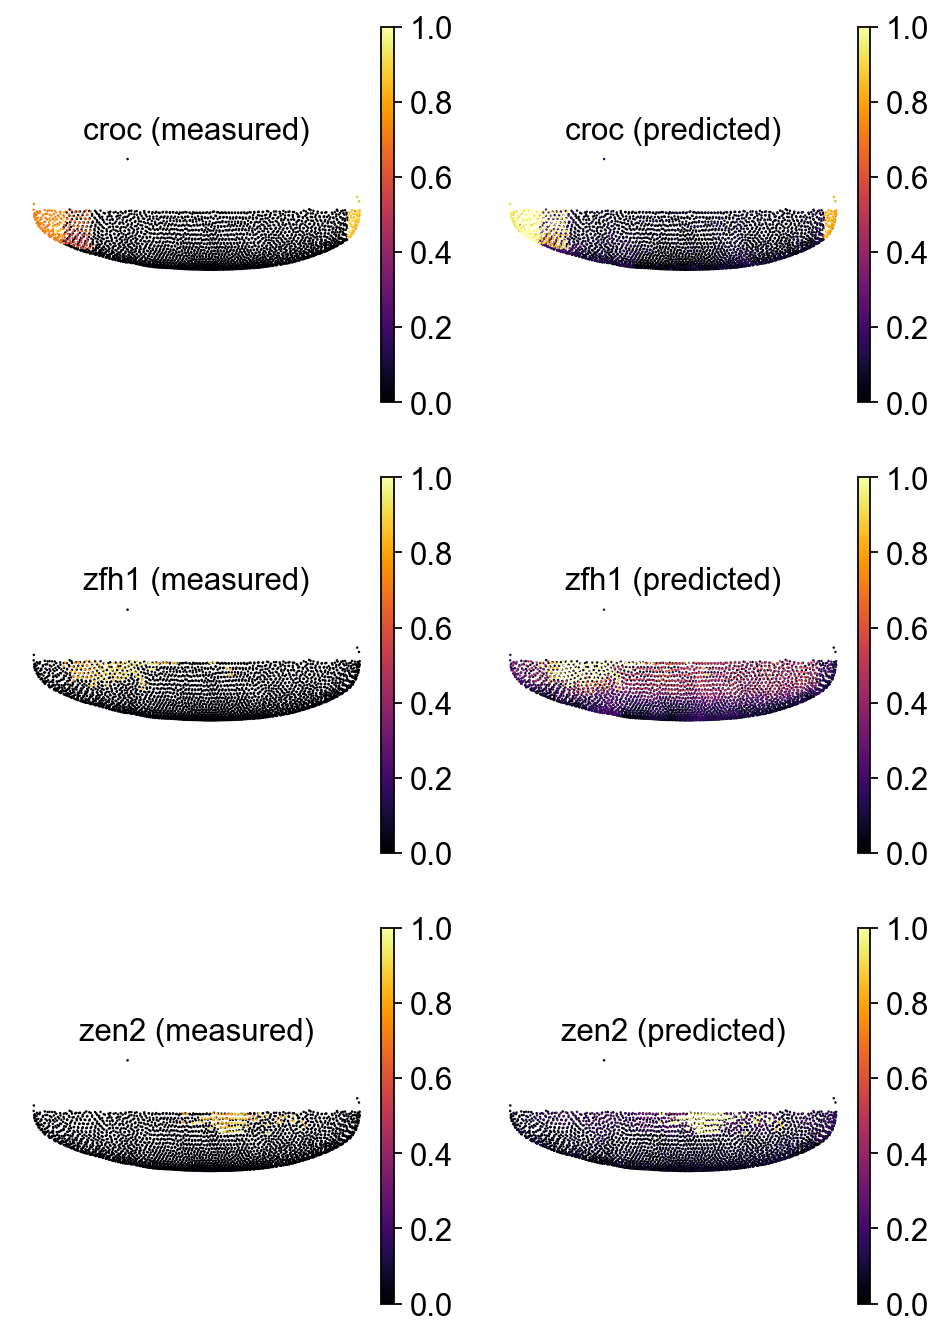

In [29]:
# The comparison between original measurements on predicted ones is easily done with tangram
tg.plot_genes_sc(   
    genes,
    adata_measured=adata_st,
    adata_predicted=ad_ge,
    perc=0.02,
    spot_size=3,
)

#### Plotting genes that were not part of the training data

We can also inspect genes there were part of the training genes but not detected in the spatial data.

In [31]:
genes_sc = list(set(adata_sc.var_names.values).difference(set(adata_st.var_names.values)))
genes_sc

['cg13101',
 'cr43962',
 'cg8370',
 'cg14244',
 'mos',
 'cct1',
 'tim17b2',
 'beat-iiic',
 'stwl',
 'cg14516',
 'cg4194',
 'flo2',
 'pkc98e',
 'cg30401',
 'cg32767',
 'cg13760',
 'cg9272',
 'dscam1',
 'nrv3',
 'tkr86c',
 'eth',
 'lobo',
 'cg17018',
 'beat-vc',
 'toy',
 'cg13893',
 'cg13405',
 'lapsyn',
 'cg12164',
 'p120ctn',
 'cg6123',
 'bigh1',
 'skeletor',
 'lig',
 'cr30009',
 'fd64a',
 'cr44652',
 'ventrally-expressed-protein-d',
 'cg17029',
 'cr45700',
 'cr43432',
 'msl-2',
 'cg5002',
 'a',
 'cg7685',
 'cg32572',
 'cg34323',
 'cr43724',
 'xrcc1',
 'obp99a',
 'pka-c2',
 'cr45126',
 'cg10055',
 'cg3967',
 'twdlv',
 'cr44732',
 'cr44594',
 'byn',
 'cr44024',
 'rhp',
 'cg11404',
 'jeb',
 'sds22',
 'sifa',
 'cg43736',
 'kay',
 'cr44619',
 'ppk6',
 'robo3',
 'takl2',
 'cg33156',
 'trf4-2',
 'cg31221',
 'ind',
 'btsz',
 'hep',
 'uzip',
 'l(3)psg2',
 'fog',
 'ben',
 'fok',
 'rab5',
 'cg4565',
 'tsl',
 'blanks',
 'cg10249',
 'rk',
 'cg5059',
 'grn',
 'mthl14',
 'rcd2',
 'cg3408',
 'cg15047

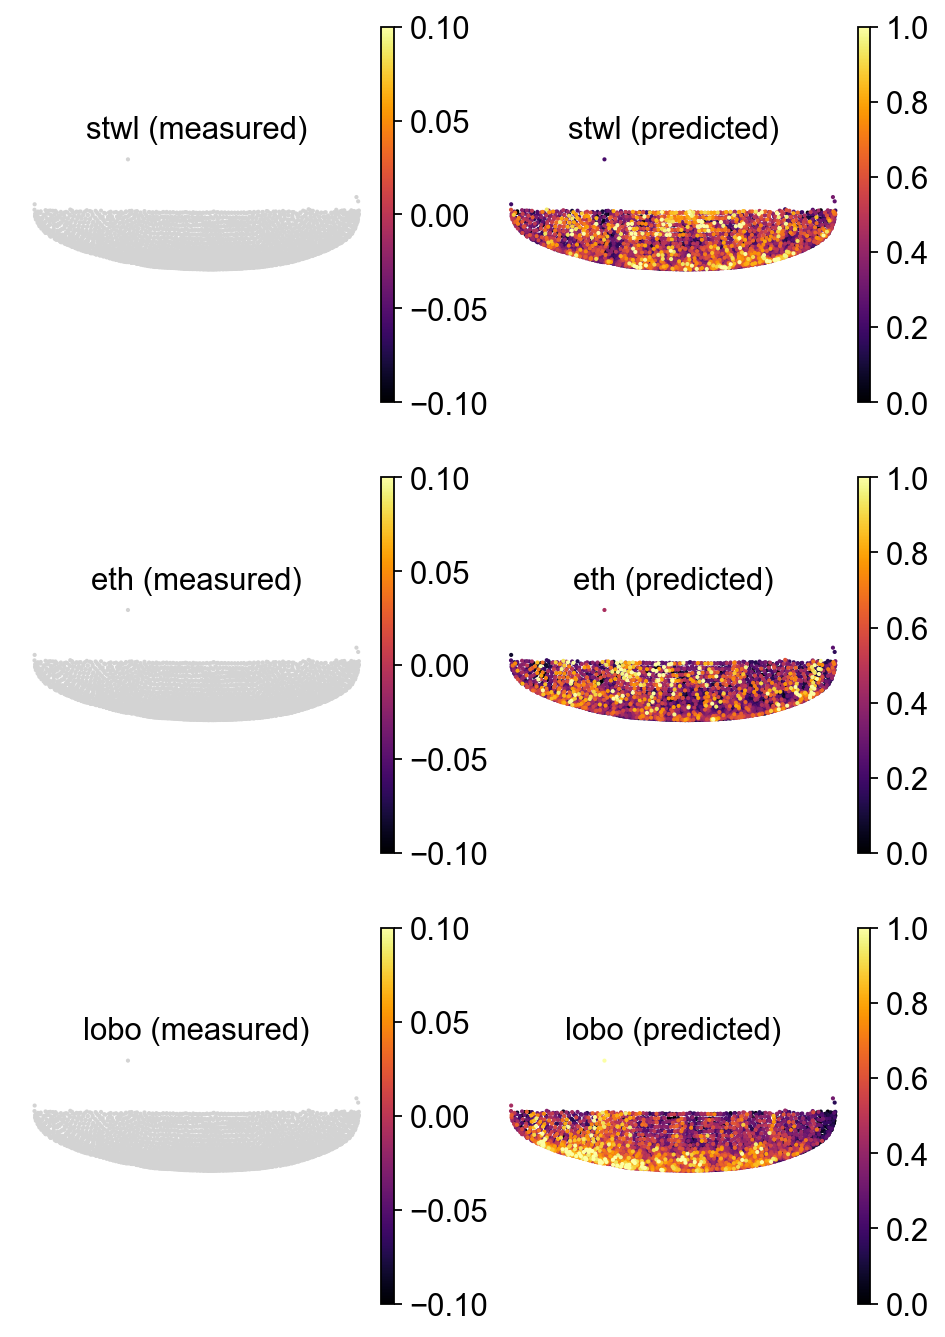

In [33]:
genes = ["stwl", "eth", "lobo"]
tg.plot_genes_sc(
    genes,
    adata_measured=adata_st,
    adata_predicted=ad_ge,
    perc=0.02,
    spot_size=5,
)

As we can see, Tangram projected the additional features onto space and we have now access to all additional genes and their estimated value at each spatial coordinate.

## Mapping single-cell gene expression in space with moscot

With moscot, it is possible to learn a single-cell-to-spatial mapping by leveraging Fused Gromov-Wasserstein (FGW) optimal transport {cite}`vayer:2018`. A basic description of the algorithm is the following:

Given a set of observations that share some features in the metric space, and some other features in different metric spaces, the FGW method aims at finding the optimal matching between these two set of observations, based both on shared and unique features. In our case:

- the "shared" metric space could be the one defined by a set of genes that were measured in both single-cell and spatial transcriptomics data.
- the "unique" metric spaces are the genes only measured in single-cell data and the spatial coordinates for the spatial transcriptomics data.

### Prepare the MappingProblem

The moscot {class}`~moscot.problems.space.MappingProblem` interfaces the FGW algorithm in a user-friendly API. First, let's initialize the {class}`~moscot.problems.space.MappingProblem` by passing single-cell and spatial {class}`~anndata.AnnData` objects.

In [3]:
from moscot.problems.space import MappingProblem
mp = MappingProblem(adata_sc=adata_sc, adata_sp=adata_st)

After initialization, we need to {meth}`~moscot.problems.space.MappingProblem.prepare` the problem. In this particular case, we need to pay attention to 3 parameters:

- `sc_attr`: specify the attribute in {class}`~anndata.AnnData` that we want to use for the features (genes) in the unique space. Usually, it's the {attr}`~anndata.AnnData.X` attribute, which contains normalized counts, but a pre-computed PCA could also be used.
  Furthermore, for the `unique` features it might be desirable to use some other type of modality, for instance protein expression or ATAC-seq measurements, that could be stored for example in {attr}`~anndata.AnnData.obsm`.
- `var_names`: specify the set of genes that we desire to be using for the `shared` space, that is the common set of genes in both dataset. If set to {obj}`None`, it will try to compute the intersection between
  the single-cell and spatial gene names.
- `joint_attr`: it is possible to also specify some other attributes that might be used for the "shared" features space, for instance, an embedding such as PCA.

If the number of shared features is large enough, it is also possible to compute a PCA on the "shared" gene space (by passing the `callback_kwargs`). We advise this if we are in the settings of $>50$ genes shared between the two datasets.

In [4]:
mp = mp.prepare(
    sc_attr={"attr": "obsm", "key": "X_pca"}, 
)

INFO     Computing pca with `n_comps=30` for `xy` using `adata.X`                                                  
computing PCA
    with n_comps=30
    finished (0:00:00)
INFO     Normalizing spatial coordinates of `x`.                                                                   


### Solve the {class}`~moscot.problems.space.MappingProblem`

We are now ready to {meth}`~moscot.problems.space.MappingProblem.solve` the problem. The most important parameter to take into account is the `alpha` value, which balances the weight of each loss ("unique" vs. "shared" spaces). With alpha close to $0$, the "shared" space loss is weighted more, with alpha close to $1$, the "unique" space loss is balanced more. For the purpose of this example, we'll use `alpha=0.5` but we suggest to increase if only a few features are present. It should take maximum one minute on a laptop.

In [5]:
mp = mp.solve(threshold=1e-3)

INFO     Solving `1` problems                                                                                      
INFO     Solving problem OTProblem[stage='prepared', shape=(3039, 1297)].                                          


In [13]:
mp[("src","tgt")].solution._output.errors

In [14]:
mp[("src","tgt")].solution._output.errors

## Analysis of the transport plan

The first thing we might be interested in doing is "imputing" genes that were not present in the spatial data. We can do so by using the {meth}`~moscot.problems.space.MappingProblem.impute` method.  If you are working on a GPU with large data, you might want to pass `device='cpu'` to the method in order to use the CPU memory for this task. For the purpose of the tutorial, we will select few genes from the single-cell data.

In [68]:
genes = ["croc", "jigr1", "nuse", "scb", "chrb", "eth", "lobo", "zen2"]
adata_imputed = mp.impute(var_names=genes)

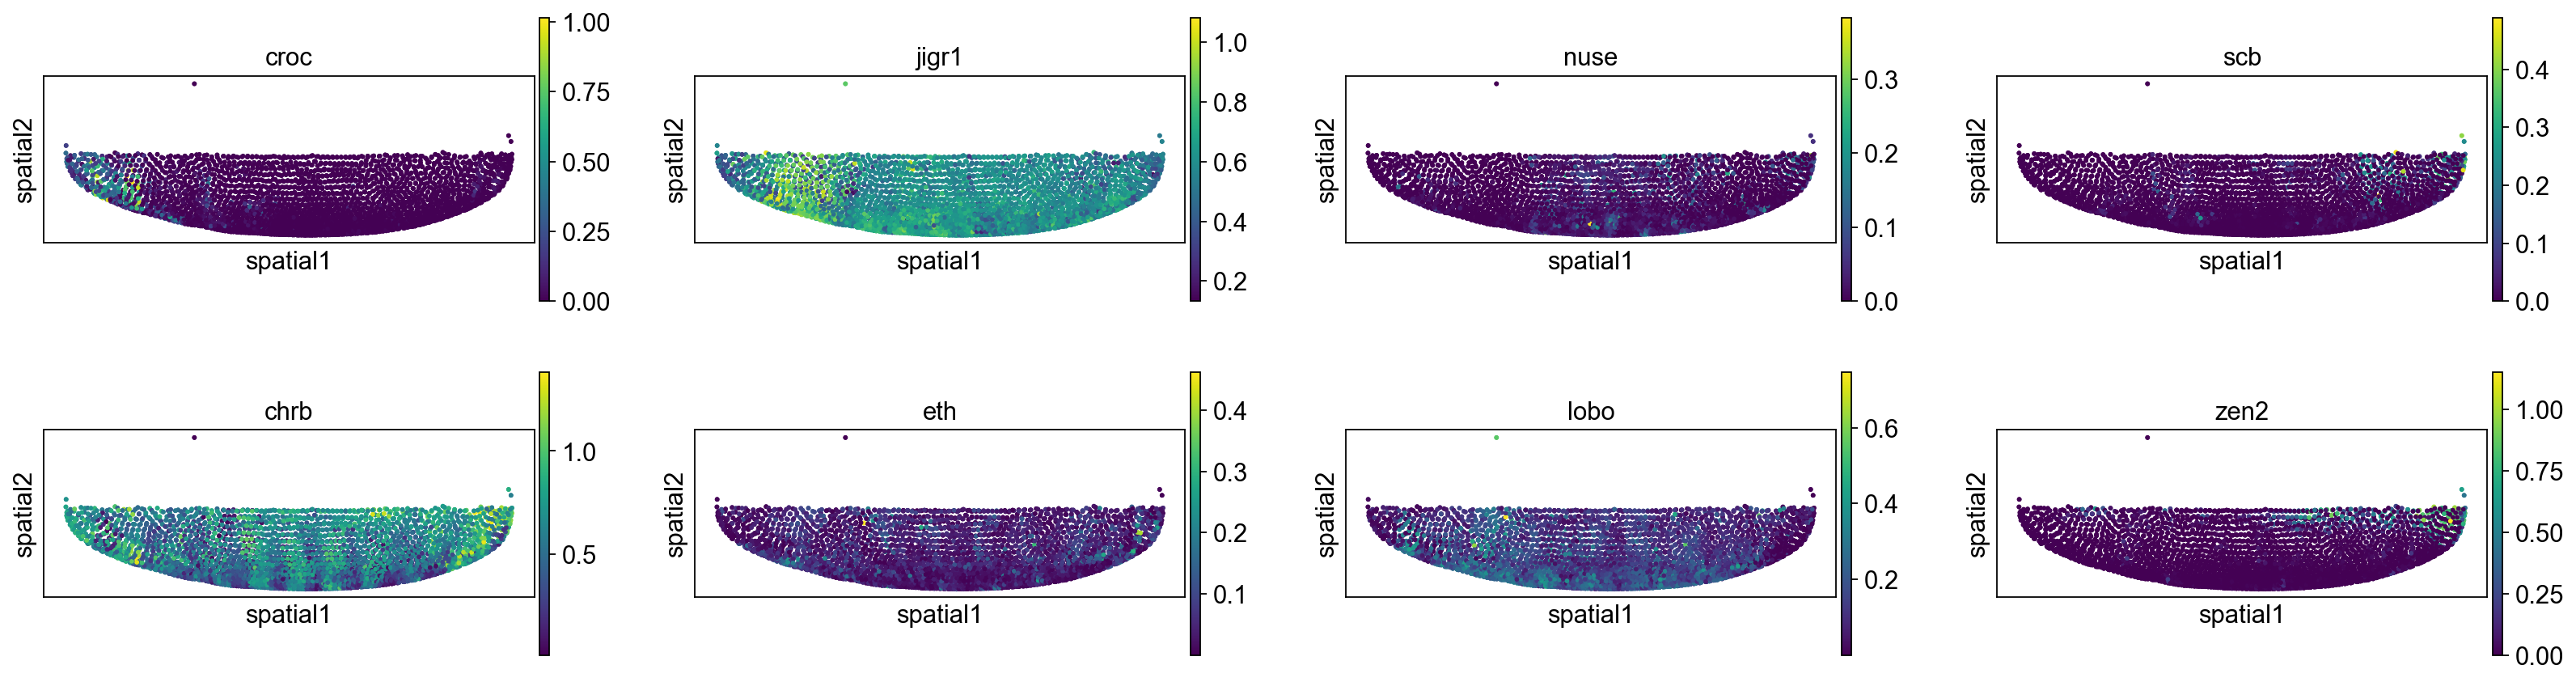

In [69]:
sq.pl.spatial_scatter(
    adata_imputed,
    spatial_key="spatial",
    color=genes,
    shape=None,
    size=10,
    figsize=(5, 3),
)

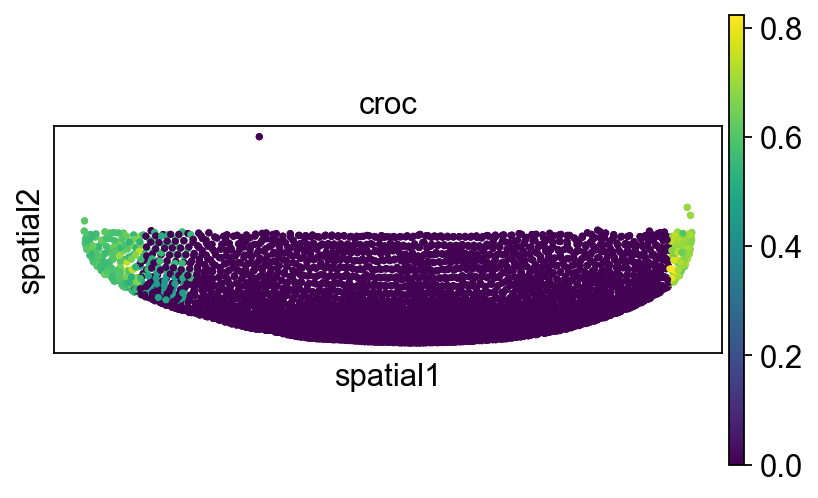

In [70]:
sq.pl.spatial_scatter(
    adata_st,
    spatial_key="spatial",
    color="croc",
    shape=None,
    size=20,
    figsize=(5, 3),
)

Another analysis function that we provide is computing gene expression correlation between inferred and ground-truth spatial genes. We can do this with the {meth}`~moscot.problems.space.MappingProblem.correlate` method.

In [41]:
corr = mp.correlate()
corr["src", "tgt"]

odd        0.633110
gk         0.429321
cg10479    0.404746
cg43394    0.620484
ilp4       0.867799
             ...   
neta       0.738806
erm        0.546278
sna        0.858251
kr         0.732021
apt        0.558384
Length: 82, dtype: float64

Finally, we provide a helper function to compute "spatial correspondence", that is, the average expression distance at increasing spatial distance, as originally proposed by *NovoSpaRc* {cite}`nitzan:19`. 
If a strong spatial correspondence is observed (as in this case) it can be useful to increase the `alpha` value.

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


<Axes: xlabel='index_interval', ylabel='features_distance'>

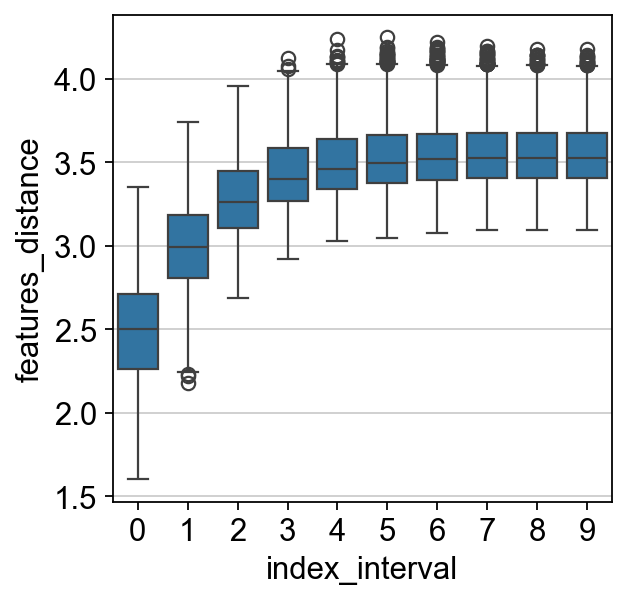

In [42]:
df = mp.spatial_correspondence(max_dist=400)
sns.boxplot(x="index_interval", y="features_distance", data=df)

# Key takeaways

* targeted in-situ technologies (such as MERFISH, smFISH, or seqFISH+) are limited in their gene throughput and typically only capture a few hundreds of preselected genes

* imputation methods aim to increase the resolution with respect to genes and generating whole transcriptome resolved spatially resolved data at single-cell resolution

* Tangram outperformed other imputation methods in in terms of different accuracy metrics and scalability

* Running a validation step on the shared features and their expression levels can help to assess whether the imputation algorithm worked well

# References

```{bibliography}
:filter: docname in docnames
:labelprefix: spatial
```

# Contributors
## Authors
* Leon Hetzel
* Anna Schaar

## Reviewers
* Lukas Heumos